# **1. Importing Libraries and Loding Data**

In [65]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Loading dataset
df = pd.read_csv('/content/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#**2. Data Preprocessing**

In [66]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Initializing the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    #Converting to lowercase
    text = text.lower()
    #Removing special characters, numbers, and extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    #Tokenizing the text
    tokens = nltk.word_tokenize(text)
    #Removing stopwords and perform lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

#Applying the preprocessing to the reviews
df['cleaned_reviews'] = df['review'].apply(preprocess_text)
df['cleaned_reviews'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,cleaned_reviews
0,one reviewer mentioned watching oz episode you...
1,wonderful little production br br filming tech...
2,thought wonderful way spend time hot summer we...
3,basically there family little boy jake think t...
4,petter matteis love time money visually stunni...


**2.1 Checking Class Imbalance**

<ipython-input-67-0fe6f514e72c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette='Set2')


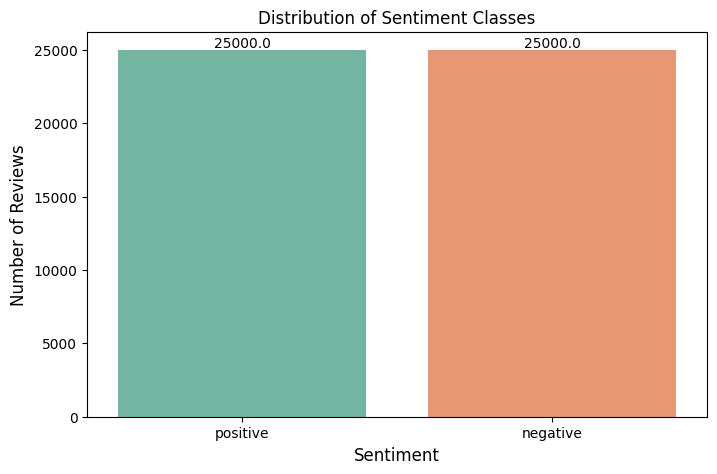

In [67]:
#Plotting the count of each sentiment class
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='sentiment', data=df, palette='Set2')

#Adding title and labels
plt.title("Distribution of Sentiment Classes", fontsize=12)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)

#Adding data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()

**2.2 Checking word occurence frequency**

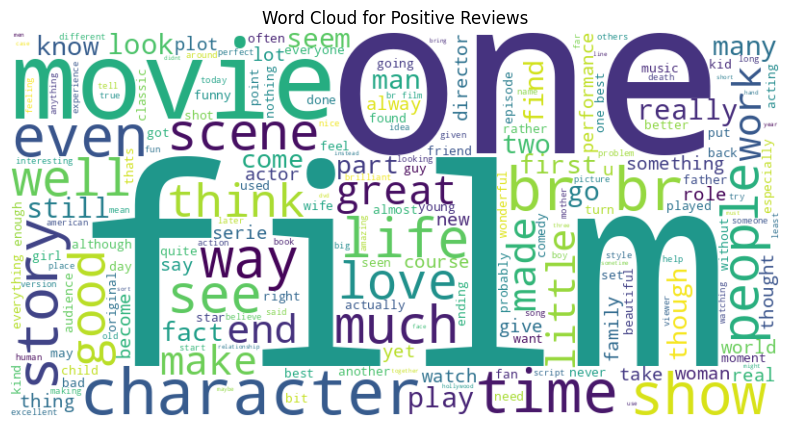

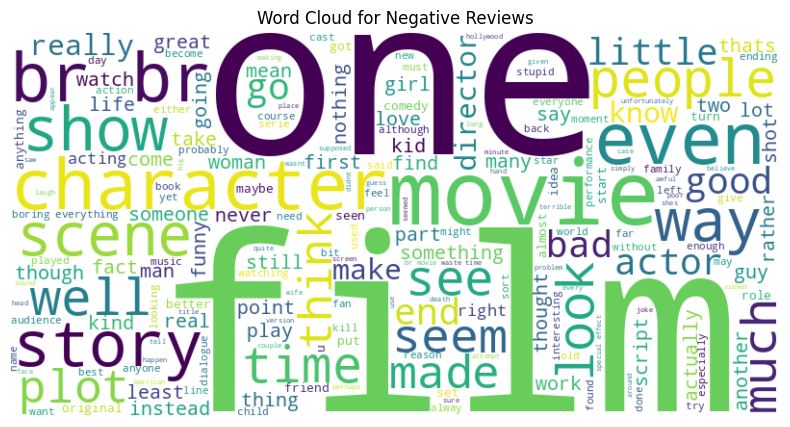

In [68]:
#Word cloud for positive reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['cleaned_reviews'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title("Word Cloud for Positive Reviews")
plt.axis('off')
plt.show()

#Word cloud for negative reviews
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['cleaned_reviews'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title("Word Cloud for Negative Reviews")
plt.axis('off')
plt.show()

**2.3 TF-IDF Analysis**

<ipython-input-69-431cd24c7f22>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words.values, y=top_words.index, palette='Spectral')


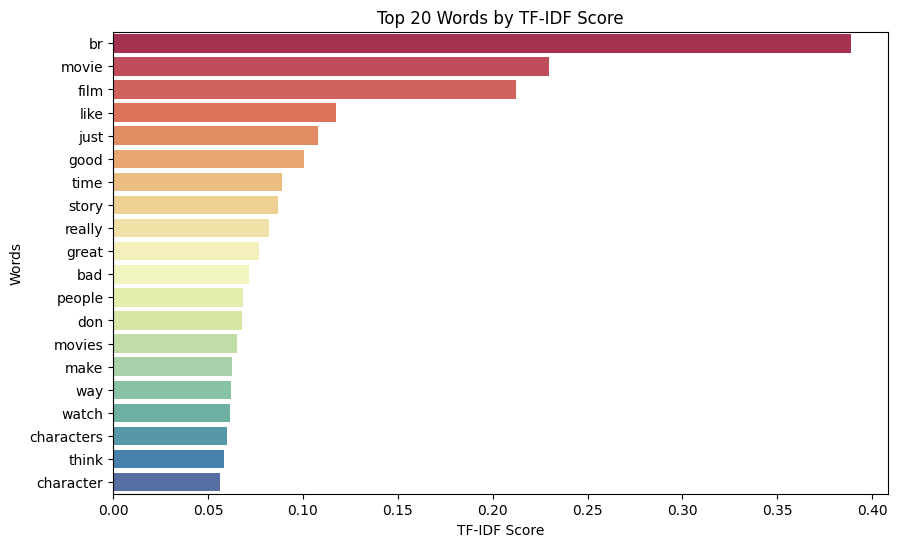

In [69]:
#Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['review'])

#Get feature names and their scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
top_words = tfidf_df.mean().sort_values(ascending=False).head(20)

#Plotting the TF-IDF scores
plt.figure(figsize=(10, 6))
sns.barplot(x=top_words.values, y=top_words.index, palette='Spectral')
plt.title('Top 20 Words by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

#**3. Feature Extraction with Bag of Words and TF-IDF**

In [70]:
#Bag-of-Words Vectorizer
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(df['cleaned_reviews']).toarray()

#TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_reviews']).toarray()

#Encoding the labels
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
y = df['label']

#**4. Train-Test Split**

In [71]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

#**5. Model Training and Evaluation**

**5.1 Logistic Regression using Bag-of-Words**

In [72]:
#Training the model with BoW features
model_bow = LogisticRegression()
model_bow.fit(X_train_bow, y_train)

#Making predictions
y_pred_bow = model_bow.predict(X_test_bow)

#Evaluating the model
print("Classification Report (BoW):\n", classification_report(y_test, y_pred_bow))
print("Bag-of-Words model Accuracy:", accuracy_score(y_test, y_pred_bow))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report (BoW):
               precision    recall  f1-score   support

           0       0.87      0.86      0.87      4961
           1       0.87      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Bag-of-Words model Accuracy: 0.871


**5.2 Logistic Regression using TF-IDF**

In [73]:
#Training the model with TF-IDF features
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train_tfidf, y_train)

#Making predictions
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

#Evaluating the model
print("Classification Report (TF-IDF):\n", classification_report(y_test, y_pred_tfidf))
print("TF-IDF model Accuracy:", accuracy_score(y_test, y_pred_tfidf))

Classification Report (TF-IDF):
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

TF-IDF model Accuracy: 0.8846


**5.3 Visualize Results**

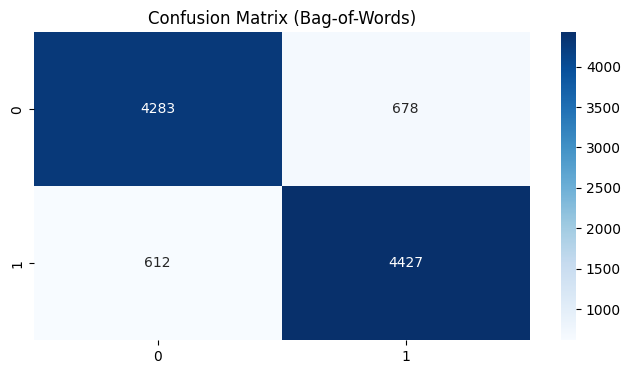

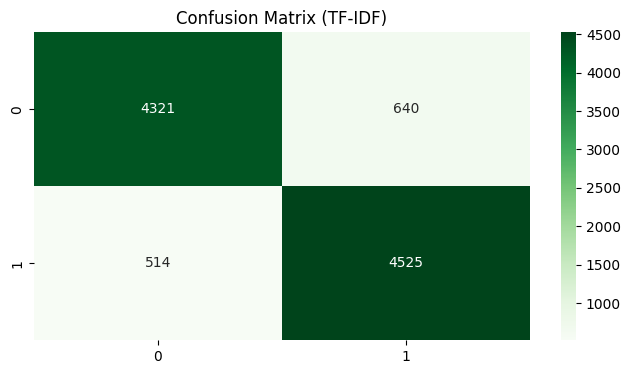

In [74]:
#Confusion matrix for Bag of Words
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_bow), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Bag-of-Words)')
plt.show()

#Confusion matrix for TF-IDF
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_tfidf), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (TF-IDF)')
plt.show()

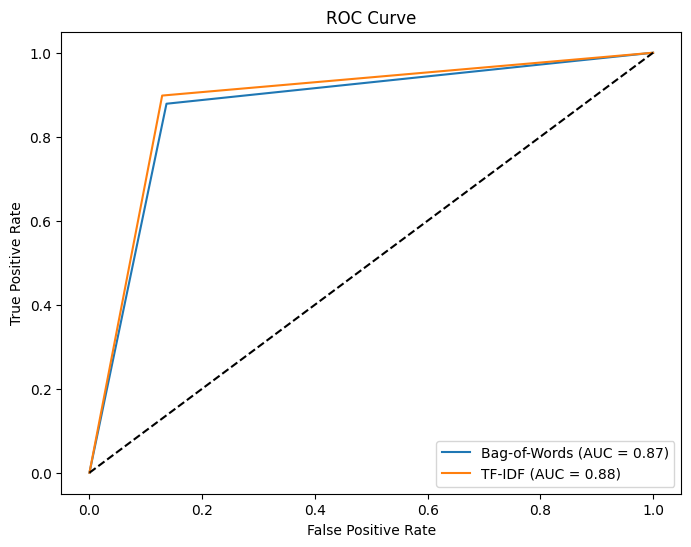

In [75]:
#ROC curve for Bag-of-Words model
fpr_bow, tpr_bow, thresholds_bow = roc_curve(y_test, y_pred_bow)
roc_auc_bow = auc(fpr_bow, tpr_bow)

#ROC curve for TF-IDF model
fpr_tfidf, tpr_tfidf, thresholds_tfidf = roc_curve(y_test, y_pred_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

#Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_bow, tpr_bow, label='Bag-of-Words (AUC = %0.2f)' % roc_auc_bow)
plt.plot(fpr_tfidf, tpr_tfidf, label='TF-IDF (AUC = %0.2f)' % roc_auc_tfidf)
plt.plot([0, 1], [0, 1], 'k--')  #Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

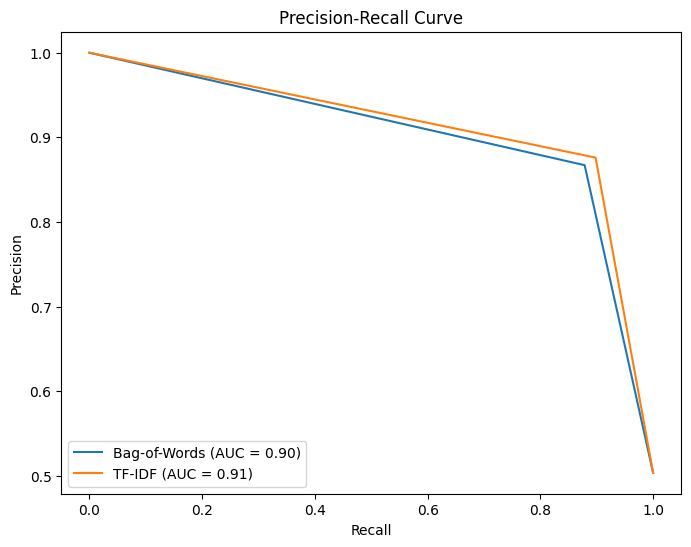

In [76]:
#Precision-recall curve for Bag-of-Words model
precision_bow, recall_bow, thresholds_bow = precision_recall_curve(y_test, y_pred_bow)
pr_auc_bow = auc(recall_bow, precision_bow)

#Precision-recall curve for TF-IDF model
precision_tfidf, recall_tfidf, thresholds_tfidf = precision_recall_curve(y_test, y_pred_tfidf)
pr_auc_tfidf = auc(recall_tfidf, precision_tfidf)

#Plotting precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall_bow, precision_bow, label='Bag-of-Words (AUC = %0.2f)' % pr_auc_bow)
plt.plot(recall_tfidf, precision_tfidf, label='TF-IDF (AUC = %0.2f)' % pr_auc_tfidf)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

#**6. Save Models and Vectorizers**

In [77]:
import joblib

joblib.dump(model_bow, 'logistic_regression_bow.pkl')
joblib.dump(bow_vectorizer, 'bow_vectorizer.pkl')

joblib.dump(model_tfidf, 'logistic_regression_tfidf.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']